# Lagrange opt
## Combinations

* Import libraries
* Define the combine function to generate all the possible combination among elements of a matrix
* Init variables

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as pl

def combine(*pools):
    result = [[]]
    for pool in pools: #for each scene
        result = [x+[y] for x in result for y in pool] #nested loop
    #add a new column at each loop and the rows required to cover all possibilities
    for prod in result: #return an iterable generator
        yield prod

source = "testscene"
filepath = "rd_results/rd_" + source + ".json"

with open(filepath, 'r') as r:
    i_data = json.load(r)
    
s_rates = np.zeros(shape=(3,5), dtype=int) #TODO: auto
s_dists = np.zeros(shape=(3,5)) #TODO: auto
i = 0 #cfr index
scene_count = 0 #store past scene index

# !! TODO: scene to shot !!
for item in i_data:
    if(item["codec"] == "hevc"):
        scene_index = item["scene_index"]
        if(scene_index != scene_count): #when the shot changes
            i = 0
            scene_count = scene_index
        s_rates[scene_index, i] = item["bitrate"]
        s_dists[scene_index, i] = 100 - item["vmaf"]
        i += 1

t = 6 #TODO compute
rates = np.einsum('ij->i', list(combine(*s_rates))) / t #rate (pesta) vs bitrate (solo somma)
dists = np.einsum('ij->i', list(combine(*s_dists))) / (scene_count + 1) #sum of rows
# media pesata

plot results

In [ ]:
pl.plot(rates, dists, 'bo')
pl.xlabel("bitrate/sec")
pl.ylabel("distortion (IVMAF)")
pl.grid(True)

target_rate = 12000000
target_dist = 100 - 80
opt_dist = True

## Discrete opt with Lagrange
* opt not absolute, but with a target rate? Or also dist?
 1 relative vmafs and rate
 2 absolute slope tangent (calcolando tutti i punti o con stima come fatto)
* is there the need to describe the convex hull? no
 nooo

Bisection algorithm:
Find the initial lambda value
* (coding unit = shot ??) each coding unit is made of a combination of shots coded at different crfs.
 
* why more minima and maxima?
 sequenza no scena
 
* how to compute again TOT Rc and Dc? TOT?
stop when current rate = max rate, otherwise compute again lambda (same formula):
- if it's more new Rr = Rc (Rc è complessivo)
- if it's less new Rl = Rc
verifica alg calcolando tutti punti e differenza

In [ ]:
import json
import numpy as np
from scipy.optimize import curve_fit

def find_closest(arr, val):
    idx = (np.abs(arr - val)).argmin()
    return idx
def log_fit(x, a, b, c):
    return a * np.log(x + b) + c

source = "forest"
filepath = "rd_results/rd_" + source + ".json"
bitrates = []
vmafs = []

with open(filepath, 'r') as r:
    i_data = json.load(r)
for item in i_data:
    if(item["codec"] == "vp9"):
        bitrates.append(item["bitrate"])
        vmafs.append(item["vmaf"])
num_samples = (max(bitrates) - min(bitrates)) / 26

#LOG CURVE FITTING
popt, pcov = curve_fit(log_fit, bitrates, vmafs, maxfev=2000)
xnew = np.arange(min(bitrates), max(bitrates)+num_samples, num_samples)
interp_vmaf = log_fit(xnew, *popt)

#SELECT TARGET
target_bitrate = 12000000
target_vmaf = 98
opt_dist = True
if(opt_dist):
    crf = find_closest(interp_vmaf, target_vmaf)
else:
    crf = find_closest(xnew, target_bitrate)
print(crf + 15)

In [ ]:
import matplotlib.pyplot as pl

pl.plot(bitrates, vmafs, 'bo')
pl.plot(xnew, interp_vmaf, 'r')
pl.grid(True)

#TODO: covariance testing, MSE assessment

The same but with RD:

In [ ]:
import json
import numpy as np
from scipy.optimize import curve_fit

def find_closest(arr, val):
    idx = (np.abs(arr - val)).argmin()
    return idx

def log_fit(x, a, b, c): #anche polinomio 2 grado
    return a * np.log(x + b) + c      

source = "forest"
filepath = "rd_results/rd_" + source + ".json"
rates = []
dists = []

with open(filepath, 'r') as r:
    i_data = json.load(r)
for item in i_data:
    if(item["codec"] == "hevc"):
        rates.append(item["bitrate"])
        dists.append(100 - item["vmaf"])
num_samples = (max(rates) - min(rates)) / 25 #to change

target_rate = 12000000
target_dist = 100 - 80
opt_dist = True

#LOG CURVE FITTING
popt, pcov = curve_fit(log_fit, rates, dists, maxfev=1000)
xrate = np.arange(min(rates), max(rates) + num_samples, num_samples)
ydist = np.asarray(log_fit(xrate, *popt))
if(opt_dist):
    crf = find_closest(ydist, target_dist)
else:
    crf = find_closest(xrate, target_rate)
print(crf + 15) #to change

In [ ]:
import matplotlib.pyplot as pl

pl.plot(rates, dists, 'bo')
pl.plot(xrate, ydist, 'r')
pl.grid(True)

In [ ]:
#NORMALIZATION
rates = np.asarray(rates)
dists = np.asarray(dists)
nx = (xrate - min(xrate))/(max(xrate) - min(xrate))
ny = (ydist - min(ydist))/(max(ydist) - min(ydist))
#npopt, npcov = curve_fit(log_fit, nx, ny, maxfev=1000)
#num_samples = 1 / 25 #to change
#nxrate = np.arange(min(nx), max(nx) + num_samples, num_samples)
#nydist = np.asarray(log_fit(nxrate, *popt))
ncrf = np.argmin(np.sqrt(np.add(nx**2, ny**2))) 
print(ncrf + 15)

In [ ]:
import matplotlib.pyplot as pl

x1 = nx[ncrf]
y1 = ny[ncrf]
pl.plot(x1, y1, 'go')
pl.plot(nx, ny, 'r')
pl.grid(True)

5


<Figure size 432x288 with 0 Axes>

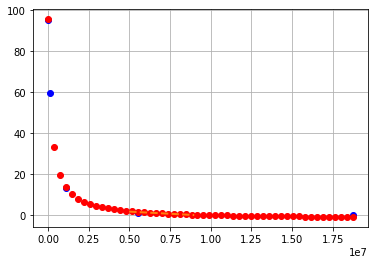

<Figure size 432x288 with 0 Axes>

In [86]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as pl

def density_space(xs, ps, n, endpoint=False, order=1):
    from scipy.interpolate import interp1d
    from scipy.integrate import cumtrapz
    
    cps = cumtrapz(ps, xs, initial=0)
    cps *= (1/cps[-1])
    intfunc = interp1d(cps, xs, kind=order)
    return intfunc(np.linspace(0, 1, n, endpoint=endpoint))

def compute_slope(xl,yl,xr,yr):
    return -(yl-yr)/(xl-xr)
def eq_fit(x, a, b, c):
    #return a * np.log(x + b) + c
    #return a*x**2 + b*x + c
    #return c + (a / np.log2(x + b))
    return a / (x + b) + c
def as_slope(x, a):
    return a / (x ** 2)
def line(x, x1, y1):
    return -as_slope(x1, par[0])*(x - x1) + y1
def show_tangent(x1,y1):
    # Define x data range for tangent line
    xrange = np.linspace(x1-2000000, x1+2000000, 2)
    pl.plot(xrange, line(xrange, x1, y1), 'C1--', linewidth = 2)

crf = [0, 13, 26, 38, 51]
rates = [18729544, 5554671, 1085638, 138604, 12974]
dists = [8.0860000e-03, 1.0444440e+00, 1.2928326e+01, 5.9431145e+01, 9.5521998e+01]
par, cov = curve_fit(eq_fit, rates, dists)
num_samples = (max(rates) - min(rates)) / 51 #to change
xnew = np.arange(min(rates), max(rates)+num_samples, num_samples)
#xnew = density_space(rates,eq_fit(rates, *par),n=52, endpoint=True)
fun_curve = eq_fit(xnew, *par)
t_ext = compute_slope(rates[4],dists[4],rates[0],dists[0])
#print("t-slope: "+str("%.16f" % t_ext["slope"]))
#print(t_ext)

print(np.argmin(abs(t_ext-(par[0]/np.einsum('i,i->i',xnew,xnew)))))
#pl.plot(xnew1,fun_curve)
pl.plot(rates, dists, 'bo')
pl.plot(xnew, fun_curve, 'ro')
show_tangent(xnew[19],fun_curve[19])
pl.grid(True)
pl.figure()


In [ ]:
import matplotlib.pyplot as pl

def slope(x):
    return popt[0] / (x + popt[1])
def line(x, x1, y1):
    return slope(x1)*(x - x1) + y1
def show_tangent(x1,y1):
    # Define x data range for tangent line
    xrange = np.linspace(x1-50000000, x1+50000000, 2)
    pl.plot(xrange, line(xrange, x1, y1), 'C1--', linewidth = 2)

x1 = xrate[crf]
y1 = ydist[crf]

pl.plot(x1, y1, 'go')
pl.plot(xrate, ydist, 'r')
show_tangent(x1,y1)
pl.grid(True)

#TODO: linear inverse testing

In [ ]:
            t_intvl = [np.zeros((2,num_scenes)), np.zeros((2,num_scenes))] # t_ext[max min] ; t_ext[0][rate dist]
            s_intvl = np.zeros((2,num_scenes)) # [rate dist]
            t_ext = {"l": [], "r": [], "slope": 0.0}
            s_ext = {"l": [], "r": [], "slope": 0.0}
            t_pts = np.zeros((2,num_scenes), dtype=int) # t_pts[max min]
            s_pts = np.zeros(num_scenes, dtype=int)
            
            if point_index == 0: #if there are no points (first loop)
                shot_index = 0
                for shot in sorted(os.listdir(REF_PATH)): #for each shot
                    out = encode(shot, shot_index, max_range_crf) #encoding
                    assess(shot, out) #quality assessment
                    store_results(shot_index, max_range_crf, out)
                    r = o_data["shots"][shot_index]["assessment"]["rate"][max_range_crf]
                    d = 100 - o_data["shots"][shot_index]["assessment"]["vmaf"][max_range_crf]
                    t_pts[0][shot_index] = max_range_crf
                    t_intvl[0][0, shot_index] = r * o_data["shots"][shot_index]["duration"] / duration
                    t_intvl[0][1, shot_index] = d * o_data["shots"][shot_index]["duration"] / duration
                    shot_index += 1
                t_ext["l"] = np.einsum('ij->i',t_intvl[0])
                point_index += 1
            if point_index == 1: #if there are no points to compare (second loop)
                shot_index = 0
                for shot in sorted(os.listdir(REF_PATH)): #for each shot
                    out = encode(shot, shot_index, min_range_crf) #encoding
                    assess(shot, out) #quality assessment
                    store_results(shot_index, min_range_crf, out)
                    r = o_data["shots"][shot_index]["assessment"]["rate"][min_range_crf]
                    d = 100 - o_data["shots"][shot_index]["assessment"]["vmaf"][min_range_crf]
                    t_pts[1][shot_index] = min_range_crf
                    t_intvl[1][0, shot_index] = r * o_data["shots"][shot_index]["duration"] / duration
                    t_intvl[1][1, shot_index] = d * o_data["shots"][shot_index]["duration"] / duration
                    shot_index += 1
                t_ext["r"] = np.einsum('ij->i',t_intvl[1])
                t_ext["slope"] = compute_slope(t_ext["l"][0],t_ext["l"][1],t_ext["r"][0],t_ext["r"][1])
                #print(str("%.2f" % t_ext["l"][0])+" , "+str("%.2f" % t_ext["l"][1])+" , "+str("%.2f" % t_ext["r"][0])+" , "+str("%.2f" % t_ext["r"][1]))
                #print("t-slope: "+str("%.16f" % t_ext["slope"]))
                point_index += 1
                
            while not np.array_equal(t_pts[0],t_pts[1]):
                point_index += 1
                shot_index = 0
                for shot in sorted(os.listdir(REF_PATH)): #for each shot
                    current_point = None
                    new_point = max_range_crf
                    res_matrix = copy.deepcopy(o_data["shots"][shot_index]["assessment"])
                    res_matrix[t_name] = [np.inf if item == 0 else item for item in res_matrix[t_name]]
                    l = [res_matrix["rate"][t_pts[0][shot_index]],100-res_matrix["vmaf"][t_pts[0][shot_index]]]
                    r = [res_matrix["rate"][t_pts[1][shot_index]],100-res_matrix["vmaf"][t_pts[1][shot_index]]]
                    s_ext["l"] = np.asarray(l) * o_data["shots"][shot_index]["duration"] / duration
                    s_ext["r"] = np.asarray(r) * o_data["shots"][shot_index]["duration"] / duration
                    s_ext["slope"] = compute_slope(s_ext["l"][0],s_ext["l"][1],s_ext["r"][0],s_ext["r"][1])
                    #print(str("%.2f" % s_ext["l"][0])+" , "+str("%.2f" % s_ext["l"][1])+" , "+str("%.2f" % s_ext["r"][0])+" , "+str("%.2f" % s_ext["r"][1]))
                    s_target = compute_target(t_ext["slope"], s_ext["slope"])
                    print(s_target)
                        
                    while not current_point == new_point: #if no convergence
                        if res_matrix["crf"][new_point] == 0:
                            out = encode(shot, shot_index, new_point) #encoding
                            assess(shot, out) #quality assessment
                            store_results(shot_index, new_point, out)
                            res_matrix["crf"][new_point] = new_point #save new crf in res_matrix
                            res_matrix["rate"][new_point] = o_data["shots"][shot_index]["assessment"]["rate"][new_point]
                            res_matrix["vmaf"][new_point] = o_data["shots"][shot_index]["assessment"]["vmaf"][new_point]
                            
                        #element-wise difference between the metric and its target value
                        differences = np.asarray(abs(np.asarray(res_matrix[t_name]) - s_target))
                        i_first_min = np.argmin(differences) #the element with the value closer to the target
                        nd_diff = differences.copy()
                        nd_diff[i_first_min] = np.inf #replace the minimum with inf
                        i_second_min = np.argmin(nd_diff) #find the second minimum
                        current_point = i_first_min #the index of the point closer to the target
                        #print(str(res_matrix[t_name][i_first_min]) +" , "+str(res_matrix[t_name][i_second_min]))
                        #swap the values of the two ends if the lower end is bigger than the upper end
                        if res_matrix[t_name][i_first_min] > res_matrix[t_name][i_second_min]:
                            new_point = search_opt(t_name, s_target, res_matrix[t_name][i_first_min], \
                                        res_matrix[t_name][i_second_min], i_first_min, i_second_min)
                        elif res_matrix[t_name][i_first_min] < res_matrix[t_name][i_second_min]:
                            new_point = search_opt(t_name, s_target, res_matrix[t_name][i_second_min], \
                                        res_matrix[t_name][i_first_min], i_second_min, i_first_min)
                        else: #it may happen that the results are the same ex. black short shots
                            current_point = max(i_first_min,i_second_min)
                            new_point = current_point
                        #print("new point"+str(new_point))
                    #save current opt points in the list
                    r = o_data["shots"][shot_index]["assessment"]["rate"][current_point]
                    d = 100 - o_data["shots"][shot_index]["assessment"]["vmaf"][current_point]
                    s_pts[shot_index] = current_point
                    s_intvl[0, shot_index] = r * o_data["shots"][shot_index]["duration"] / duration
                    s_intvl[1, shot_index] = d * o_data["shots"][shot_index]["duration"] / duration
                    shot_index += 1
                #compute rl and compare it with rc
                current_target = {"rate": np.einsum('i->',s_intvl[0]), "vmaf": abs(100 - np.einsum('i->',s_intvl[1]))}
                if current_target[t_name] > t_val:
                    print("morre")
                    t_intvl[1] = s_intvl
                    t_pts[1] = s_pts
                else:
                    print("lesss")
                    t_intvl[0] = s_intvl
                    t_pts[0] = s_pts
                t_ext["l"] = np.einsum('ij->i',t_intvl[0])
                t_ext["r"] = np.einsum('ij->i',t_intvl[1])
                t_ext["slope"] = compute_slope(t_ext["l"][0],t_ext["l"][1],t_ext["r"][0],t_ext["r"][1])
                #print("t-slope: "+str("%.16f" % t_ext["slope"]))
                print("CHECK "+str(t_pts[0])+" - "+str(t_pts[1]))
            for i in range(0,num_scenes): #save the opt crf for each shot
                save_opt(i, target_index, t_pts[1][i])
            #print(t_pts[1])